In [ ]:
from pathlib import Path
import os

DAY = "20251201"
Version = "v1"

PROJECT_ROOT = Path(os.getenv("LLMSC_ROOT", ".")).resolve()

DATA_DIR = Path(os.getenv("LLMSC_DATA_DIR", PROJECT_ROOT / "input")).resolve()
OUT_DIR  = Path(os.getenv("LLMSC_OUT_DIR",  PROJECT_ROOT / "runs" / f"{DAY}.{Version}")).resolve()
OUT_DIR.mkdir(parents=True, exist_ok=True)


In [ ]:
RANDOM_SEED = 42
import random, os
import numpy as np
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🔒 Random seed set to {RANDOM_SEED} for reproducibility.")


🔒 Random seed set to 42 for reproducibility.


In [ ]:
import os
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "")
USE_LLM = bool(GEMINI_API_KEY)

if not USE_LLM:
    print("⚠️ GEMINI_API_KEY not set → LLM inference cells will be skipped.")

In [ ]:
import google.generativeai as genai
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy import sparse
from scipy import io
import adjustText
from adjustText import adjust_text
import gc
import re
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import confusion_matrix
from google.colab import userdata

import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s:%(name)s:%(message)s"
)

import llm_sc_curator
from llm_sc_curator import LLMscCurator
from llm_sc_curator.masking import FeatureDistiller

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# ==========================================
# 1. API
# ==========================================

genai.configure(api_key=GEMINI_API_KEY)
print("--- Available Models for your Key ---")
try:
    for m in genai.list_models():
        if 'generateContent' in m.supported_generation_methods:
            print(m.name)
except Exception as e:
    print(f"Error: {e}")

--- Available Models for your Key ---
models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image-preview
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-pro-image-preview
models/nano-banana-pro-preview
models/gemini-robotics-er-1.5-preview
models/gemini-2.5-computer-

In [ ]:
MODEL_NAME = 'models/gemini-2.5-pro'

# MODEL_NAME = 'models/gemini-3-pro-preview'
# MODEL_NAME = 'models/gemini-2.5-flash'
# MODEL_NAME = 'models/gemini-2.0-flash'

print(f"Using Model: {MODEL_NAME}")
model = genai.GenerativeModel(MODEL_NAME)

Using Model: models/gemini-2.5-pro


In [ ]:
save_path = OUT_DIR / "cd8_benchmark_data.h5ad"

print(f"\n Loading data...: {save_path}")
adata= sc.read_h5ad(save_path)
print("\nCell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):")
print(adata.obs['meta.cluster'].value_counts().head(10))


 Loading data...: /runs/20251201.v1/cd8_benchmark_data.h5ad

Cell counts per cluster (Should be balanced approx ~300 if 3 datasets merged):
meta.cluster
CD8.c01.Tn.MAL          300
CD8.c02.Tm.IL7R         300
CD8.c03.Tm.RPS12        300
CD8.c04.Tm.CD52         300
CD8.c05.Tem.CXCR5       300
CD8.c06.Tem.GZMK        300
CD8.c07.Temra.CX3CR1    300
CD8.c11.Tex.PDCD1       300
CD8.c10.Trm.ZNF683      300
CD8.c12.Tex.CXCL13      300
Name: count, dtype: int64


In [ ]:
adata.obs

,cancerType,patient,libraryID,loc,meta.cluster,platform,Cancer_Type,Sample_ID
TTGAACGCACGGATAG.13,ESCA,ESCA.P20181123,ESCA-P20181123-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,TTGAACGCACGGATAG.13
CCTAGCTGTTTCCACC.7,ESCA,ESCA.P20190410,ESCA-P20190410-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,CCTAGCTGTTTCCACC.7
TGATTTCCACCCTATC.5,ESCA,ESCA.P20190404,ESCA-P20190404-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,TGATTTCCACCCTATC.5
GGAGCAACAATCTACG.7,ESCA,ESCA.P20190410,ESCA-P20190410-N,N,CD8.c07.Temra.CX3CR1,10X,ESCA,GGAGCAACAATCTACG.7
GCACATAAGGAACTGC.10,ESCA,ESCA.P20190411,ESCA-P20190411-T,T,CD8.c07.Temra.CX3CR1,10X,ESCA,GCACATAAGGAACTGC.10
...,...,...,...,...,...,...,...,...
GTCACGGGTGGTAACG.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,GTCACGGGTGGTAACG.51
TCAGCTCTCTATCCCG.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,TCAGCTCTCTATCCCG.51
TGATTTCAGTATTGGA.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,TGATTTCAGTATTGGA.51
TTGCCGTCAGCCTATA.51,RC,RC.P20190923,RC-P20190923-T,T,CD8.c15.ISG.IFIT1,10X,RC,TTGCCGTCAGCCTATA.51


In [ ]:
# ==========================================
# Correct Label Generation Function
# Definition based on cluster IDs from Zheng et al. 2021
# ==========================================

def get_cd8_ground_truth(cluster_name: str) -> str:
    """
    Map Zheng et al. CD8 meta.cluster names to GT categories.

    The GT labels are intentionally slightly finer (Naive / Effector / EffectorMemory /
    Exhausted / ISG / MAIT / NK_killer / Cycling), and are later collapsed into
    coarse (major, state) pairs by CD8_HIER_CFG.gt_rules.
    """
    s = str(cluster_name).lower()

    # 1) Distinct functional states
    if "mait" in s:
        return "CD8_MAIT"

    if any(k in s for k in ["isg", "interferon", "ifit1"]):
        return "CD8_ISG"

    if any(k in s for k in ["proliferating", "cycle", "mki67", "top2a"]):
        return "CD8_Cycling"

    # 2) NK-like killer pool (exclude explicit T cell labels)
    if "nk" in s and "t cell" not in s:
        return "CD8_NK_Killer"

    # 3) Exhausted pool
    if any(k in s for k in ["tex", "exhausted", "pdcd1"]):
        return "CD8_Exhausted"

    # 4) TRM / resident memory → treated as EffectorMemory in GT
    if any(k in s for k in ["trm", "resident", "znf683", "itgae", "cd69"]):
        return "CD8_EffectorMemory"

    # 5) Naive pool (true naive; use 'tn.' to avoid Tn/Tm confusion)
    if "tn." in s or "naive" in s:
        return "CD8_Naive"

    # 6) Temra / CX3CR1-high killers
    if any(k in s for k in ["temra", "cx3cr1", "klrg1"]):
        return "CD8_Effector"

    # 7) Tem / Tm / GZMK+ effector-memory clusters
    if any(k in s for k in ["tem.", "tm.", "memory", "gzmk", "aqp3", "ltb"]):
        return "CD8_EffectorMemory"

    # 8) Tk / killer T clusters (Zheng's Tk)
    if "tk" in s or "killer" in s:
        return "CD8_Effector"

    # 9) Fallback
    return "CD8_Other"



print("Applying Ground Truth Mapping...")
adata.obs['GT_Category'] = adata.obs['meta.cluster'].apply(get_cd8_ground_truth)
print(adata.obs['GT_Category'].value_counts())


Applying Ground Truth Mapping...
GT_Category
CD8_EffectorMemory    1983
CD8_Exhausted          928
CD8_Effector           753
CD8_Naive              300
CD8_MAIT               300
CD8_ISG                202
Name: count, dtype: int64


In [ ]:
GT_KEYWORDS_CD8 = {
    "CD8_Exhausted":      ["PDCD1", "HAVCR2", "LAG3", "TOX"],
    "CD8_ISG":            ["ISG15", "IFIT1", "MX1", "STAT1"],
    "CD8_EffectorMemory": ["GZMK", "LTB", "AQP3"],
    "CD8_Effector":       ["GZMB", "PRF1", "GNLY", "CX3CR1", "KLRG1"],
    "CD8_MAIT":           ["SLC4A10", "KLRB1"],
    "CD8_Naive":          ["TCF7", "LEF1", "CCR7", "SELL"],
    "CD8_Cycling":        ["MKI67", "TOP2A"],
}


var_names = adata.var_names
filtered_markers = {k: [g for g in v if g in var_names] for k, v in GT_KEYWORDS_CD8.items()}


In [ ]:
if "highly_variable" not in adata.var.columns:
    print("[Setup] Computing global HVGs for CD8 benchmark...")

    hvg_kwargs = dict(
        n_top_genes=2000,
        subset=False,
        batch_key="Cancer_Type",
    )

    if "counts" in adata.layers:
        hvg_kwargs.update(
            flavor="seurat_v3",
            layer="counts",
        )
        print("[HVG] Using flavor='seurat_v3' on layers['counts'] with batch_key='Cancer_Type'.")
    else:
        hvg_kwargs.update(
            flavor="seurat",
        )
        print("[HVG] `layers['counts']` not found → using flavor='seurat' on log1p .X.")

    print(hvg_kwargs)

    sc.pp.highly_variable_genes(adata, **hvg_kwargs)

# Curator Initialize
curator = LLMscCurator(api_key=GEMINI_API_KEY, model_name=MODEL_NAME)
curator.set_global_context(adata)

[Setup] Computing global HVGs for CD8 benchmark...
[HVG] Using flavor='seurat_v3' on layers['counts'] with batch_key='Cancer_Type'.
{'n_top_genes': 2000, 'subset': False, 'batch_key': 'Cancer_Type', 'flavor': 'seurat_v3', 'layer': 'counts'}


In [ ]:
import sys
REPO_ROOT = os.path.join(indir, "LLM-scCurator")
sys.path.append(REPO_ROOT)

from benchmarks.hierarchical_scoring import _parse_state_generic
from benchmarks.cd8_config import CD8_HIER_CFG
from benchmarks.cd4_config import CD4_HIER_CFG
from benchmarks.mouse_b_config import MOUSE_B_CFG

from llm_sc_curator.masking import FeatureDistiller
from llm_sc_curator.noise_lists import NOISE_PATTERNS, NOISE_LISTS, CELL_CYCLE_GENES

from benchmarks.cd8_config import CD8_HIER_CFG
from benchmarks.hierarchical_scoring import score_hierarchical
from benchmarks.gt_mappings import get_cd8_ground_truth


In [ ]:
def build_noise_pool_from_package(adata, min_pool_size: int = 50) -> list:
    """
    Based on the NOISE_PATTERNS / NOISE_LISTS definitions in the package,
    extract the “biological noise candidate” genes included in this dataset.
    """
    all_genes = adata.var_names.tolist()
    noise_set = set()

    # 1. Regex (TCR, Ig, Mito, Ribo, etc.)
    for pattern in NOISE_PATTERNS.values():
        regex = re.compile(pattern)
        matches = [g for g in all_genes if regex.search(g)]
        noise_set.update(matches)

    # 2. Gene lists (Cell cycle etc...)
    for gene_set in NOISE_LISTS.values():
        matches = [g for g in all_genes if g in gene_set]
        noise_set.update(matches)

    pool = list(noise_set)

    if len(pool) < min_pool_size:
        print("   ⚠️ Dataset is very clean. Supplementing with standard confounders.")
        defaults = list(CELL_CYCLE_GENES) + [
            "ACTB", "GAPDH", "MALAT1", "NEAT1", "RPS12", "MT-CO1", "JUN", "FOS"
        ]
        pool = list(set(pool).union(defaults))

    print(f"   🦠 Biological Noise Pool Detected: {len(pool)} genes")
    print(f"      Examples: {pool[:5]}")
    return pool


In [ ]:
def build_true_marker_pool(
    adata,
    cluster_name: str,
    noise_pool: list,
    group_col: str = "meta.cluster",
    n_candidates: int = 300,
) -> list:
    """
    For the given cluster, create a pool of “true signal candidates” based on DE analysis.
    Exclude genes contained in noise_pool.
    """
    adata_temp = adata.copy()
    adata_temp.obs["binary_group"] = "Rest"
    adata_temp.obs.loc[
        adata_temp.obs[group_col] == cluster_name, "binary_group"
    ] = "Target"

    try:
        sc.tl.rank_genes_groups(
            adata_temp,
            groupby="binary_group",
            groups=["Target"],
            reference="Rest",
            method="wilcoxon",
        )
        df_de = sc.get.rank_genes_groups_df(adata_temp, group="Target")
        raw_signal = df_de["names"].tolist()
        true_markers = [g for g in raw_signal if g not in noise_pool][:n_candidates]
    except Exception as e:
        print(f"   [Warning] rank_genes_groups failed: {e}")
        true_markers = [g for g in adata.var_names if g not in noise_pool][:n_candidates]

    del adata_temp
    print(f"   ✅ True marker pool for {cluster_name}: {len(true_markers)} genes")
    print(f"      Examples: {true_markers[:5]}")
    return true_markers


In [ ]:
def run_noise_simulation(
    adata,
    cluster_name: str,
    noise_ratios=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0),
    n_markers: int = 50,
    use_mock_llm: bool = False,
    curator=None,
    random_seed: int = 42,
    n_repeats: int = 3,
    eval_fn=None,
    group_col: str = "meta.cluster",
    OUT_DIR: str = ".",
):
    """
    Validate FeatureDistiller's noise masking mechanism using an actual noise gene pool.
    - noise_ratios: Noise proportion mixed into the marker list, ranging from 0.0 to 1.0
    - n_markers: Number of genes passed to the LLM
    - use_mock_llm: When True, evaluates using idealized scores without calling the LLM (for debugging)
    - n_repeats: Number of iterations per noise ratio (Monte Carlo-style technical replicates)
    - eval_fn: A function that returns prediction, cluster_name -> [0,1]
    """
    rng = np.random.default_rng(random_seed)

    if eval_fn is None:
        eval_fn = eval_cd8_single_prediction

    gt_label = get_cd8_ground_truth(cluster_name)
    print(f"🧪 Starting Real Tool Verification for: {cluster_name}")
    print(f"   Ground truth label: {gt_label}")

    # 1. Build noise pools and signal pools (non-cluster-dependent parts only once)
    noise_pool = build_noise_pool_from_package(adata)
    true_markers_pool = build_true_marker_pool(
        adata,
        cluster_name=cluster_name,
        noise_pool=noise_pool,
        group_col=group_col,
        n_candidates=300,
    )

    # 2. Initialize Distiller once and reuse it
    distiller = FeatureDistiller(adata)
    mask_reasons_global = distiller.detect_biological_noise(
        gini_threshold=None,
        gini_q=0.01,
        mean_floor=0.01,
    )
    print(f"   🧼 Global masking definitions: {len(mask_reasons_global)} genes flagged as noise")

    results = []

    for ratio in noise_ratios:
        percentage = int(ratio * 100)
        n_noise = int(n_markers * ratio)
        n_signal = n_markers - n_noise

        print(f"\n--- Confounder Ratio: {percentage}% ---", flush=True)

        for rep in range(n_repeats):
            print(f"   ▶ Repeat {rep+1}/{n_repeats}")

            # ----------------------------------------
            # A. Garbage In (Standard) Creation
            #    Random sampling of noise & signal
            # ----------------------------------------
            # noise
            if n_noise > 0 and len(noise_pool) > 0:
                idx_noise = rng.choice(
                    len(noise_pool),
                    size=n_noise,
                    replace=(len(noise_pool) < n_noise),
                )
                current_noise = [noise_pool[i] for i in idx_noise]
            else:
                current_noise = []

            # signal
            if n_signal > 0 and len(true_markers_pool) > 0:
                idx_signal = rng.choice(
                    len(true_markers_pool),
                    size=n_signal,
                    replace=(len(true_markers_pool) < n_signal),
                )
                current_signal = [true_markers_pool[i] for i in idx_signal]
            else:
                current_signal = []

            genes_std = current_noise + current_signal
            rng.shuffle(genes_std)

            # ----------------------------------------
            # B. Curator Logic (masking + supplementation)
            # ----------------------------------------
            genes_cur_filtered = [g for g in genes_std if g not in mask_reasons_global]

            genes_cur = genes_cur_filtered[:]
            if len(genes_cur) < n_markers:
                needed = n_markers - len(genes_cur)
                # Replenish with unused signals
                refill_candidates = [g for g in true_markers_pool if g not in genes_cur]

                if needed > len(refill_candidates) and len(true_markers_pool) > 0:
                    extra_needed = needed - len(refill_candidates)
                    extra_idx = rng.choice(
                        len(true_markers_pool),
                        size=extra_needed,
                        replace=True,
                    )
                    refill_candidates.extend([true_markers_pool[i] for i in extra_idx])

                genes_cur.extend(refill_candidates[:needed])

            genes_cur = genes_cur[:n_markers]

            # ----------------------------------------
            # C. Confirming the number of residual noise
            # ----------------------------------------
            noise_in_std = [g for g in genes_std if g in noise_pool]
            noise_in_cur = [g for g in genes_cur if g in noise_pool]

            print(f"      🧬 Std Input ({len(noise_in_std)} noise): {genes_std[:5]}")
            print(f"      🧹 Cur Input ({len(noise_in_cur)} noise): {genes_cur[:5]}")
            if len(noise_in_cur) > 0:
                print(f"         ⚠️ Tool missed these noise genes: {noise_in_cur[:5]}")

            # ----------------------------------------
            # D. Classification & Scoring with LLM
            # ----------------------------------------
            if use_mock_llm:
                score_std = 1.0 if n_signal >= 10 else 0.0
                score_cur = 1.0
            else:
                try:
                    res_std_raw = curator.annotate(genes_std, use_auto_context=True)
                    score_std = float(eval_fn(res_std_raw, cluster_name))
                    time.sleep(2)

                    res_cur_raw = curator.annotate(genes_cur, use_auto_context=True)
                    score_cur = float(eval_fn(res_cur_raw, cluster_name))
                    time.sleep(2)
                except Exception as e:
                    print(f"      [Error during annotation] {e}")
                    score_std, score_cur = 0.0, 0.0
            time.sleep(1)

            print(f"      🎯 Result (rep {rep+1}): Std={score_std*100:.0f}% vs Cur={score_cur*100:.0f}%")

            results.append(
                {
                    "Cluster_ID": cluster_name,
                    "Repeat_ID": rep,
                    "Noise_Ratio": ratio,
                    "Standard_Acc": score_std * 100,
                    "Curator_Acc": score_cur * 100,
                    "N_Noise_Std": len(noise_in_std),
                    "N_Noise_Cur": len(noise_in_cur),
                }
            )

    sim_df = pd.DataFrame(results)
    sim_df.to_csv(f"{OUT_DIR}/{cluster_name}_real_tool_results.csv", index=False)
    return sim_df


In [ ]:
def eval_cd8_single_prediction(prediction, raw_cluster_name: str) -> float:
    """
    Evaluation function for CD8 noise-tolerant simulation.
    - raw_cluster_name: Example “CD8.c12.Tex.CXCL13”
    - Converts to GT labels like “CD8_Exhausted” via get_cd8_ground_truth(raw_cluster_name)
    - prediction: Return value of curator.annotate(...) (dict or str)
    Return value is [0, 1].
    """
    gt_label = get_cd8_ground_truth(raw_cluster_name)

    # Supports LLM-scCurator return value formats (dict or str)
    if isinstance(prediction, dict):
        cell_type = str(prediction.get("cell_type", ""))
        reasoning = str(prediction.get("reasoning", ""))
        text = (cell_type + " " + reasoning).strip()
    else:
        text = str(prediction).strip()

    row = pd.Series(
        {
            "Ground_Truth": gt_label,
            "Sim_Pred": text,
        }
    )

    score = score_hierarchical(row, "Sim_Pred", cfg=CD8_HIER_CFG)
    return float(score)


In [ ]:
target_cluster = "CD8.c12.Tex.CXCL13"
print(f"🎯 Target: {target_cluster}")
print(f"   Mapped GT (sanity check): {get_cd8_ground_truth(target_cluster)}")

sim_df = run_noise_simulation(
    adata,
    cluster_name=target_cluster,
    noise_ratios=(0.0, 0.2, 0.4, 0.6, 0.8),
    n_markers=50,
    use_mock_llm=False,
    curator=curator,
    random_seed=42,
    n_repeats=3,
    eval_fn=eval_cd8_single_prediction,
    group_col="meta.cluster",
    OUT_DIR=OUT_DIR,
)

print("\n--- Simulation Result ---")
print(sim_df[["Noise_Ratio", "Standard_Acc", "Curator_Acc", "N_Noise_Std", "N_Noise_Cur"]])


🎯 Target: CD8.c12.Tex.CXCL13
   Mapped GT (sanity check): CD8_Exhausted
🧪 Starting Real Tool Verification for: CD8.c12.Tex.CXCL13
   Ground truth label: CD8_Exhausted
   🦠 Biological Noise Pool Detected: 1235 genes
      Examples: ['LINC01508', 'LINC00511', 'HIST1H4D', 'SAE1', 'LINC00968']
   ✅ True marker pool for CD8.c12.Tex.CXCL13: 300 genes
      Examples: ['DUSP4', 'CXCL13', 'CD82', 'CTLA4', 'PHLDA1']
   🧼 Global masking definitions: 1255 genes flagged as noise

--- Confounder Ratio: 0% ---
   ▶ Repeat 1/3
      🧬 Std Input (0 noise): ['FKBP1A', 'CXCR6', 'CCT3', 'SUMO2', 'CAPG']
      🧹 Cur Input (0 noise): ['FKBP1A', 'CXCR6', 'CCT3', 'SUMO2', 'CAPG']
      🎯 Result (rep 1): Std=100% vs Cur=100%
   ▶ Repeat 2/3
      🧬 Std Input (0 noise): ['MYL6', 'PKM', 'KLRC1', 'RAB7A', 'BAX']
      🧹 Cur Input (0 noise): ['MYL6', 'PKM', 'KLRC1', 'RAB7A', 'BAX']
      🎯 Result (rep 2): Std=100% vs Cur=70%
   ▶ Repeat 3/3
      🧬 Std Input (0 noise): ['TNIP3', 'PDLIM7', 'IKZF3', 'SOD1', 'PTMS']


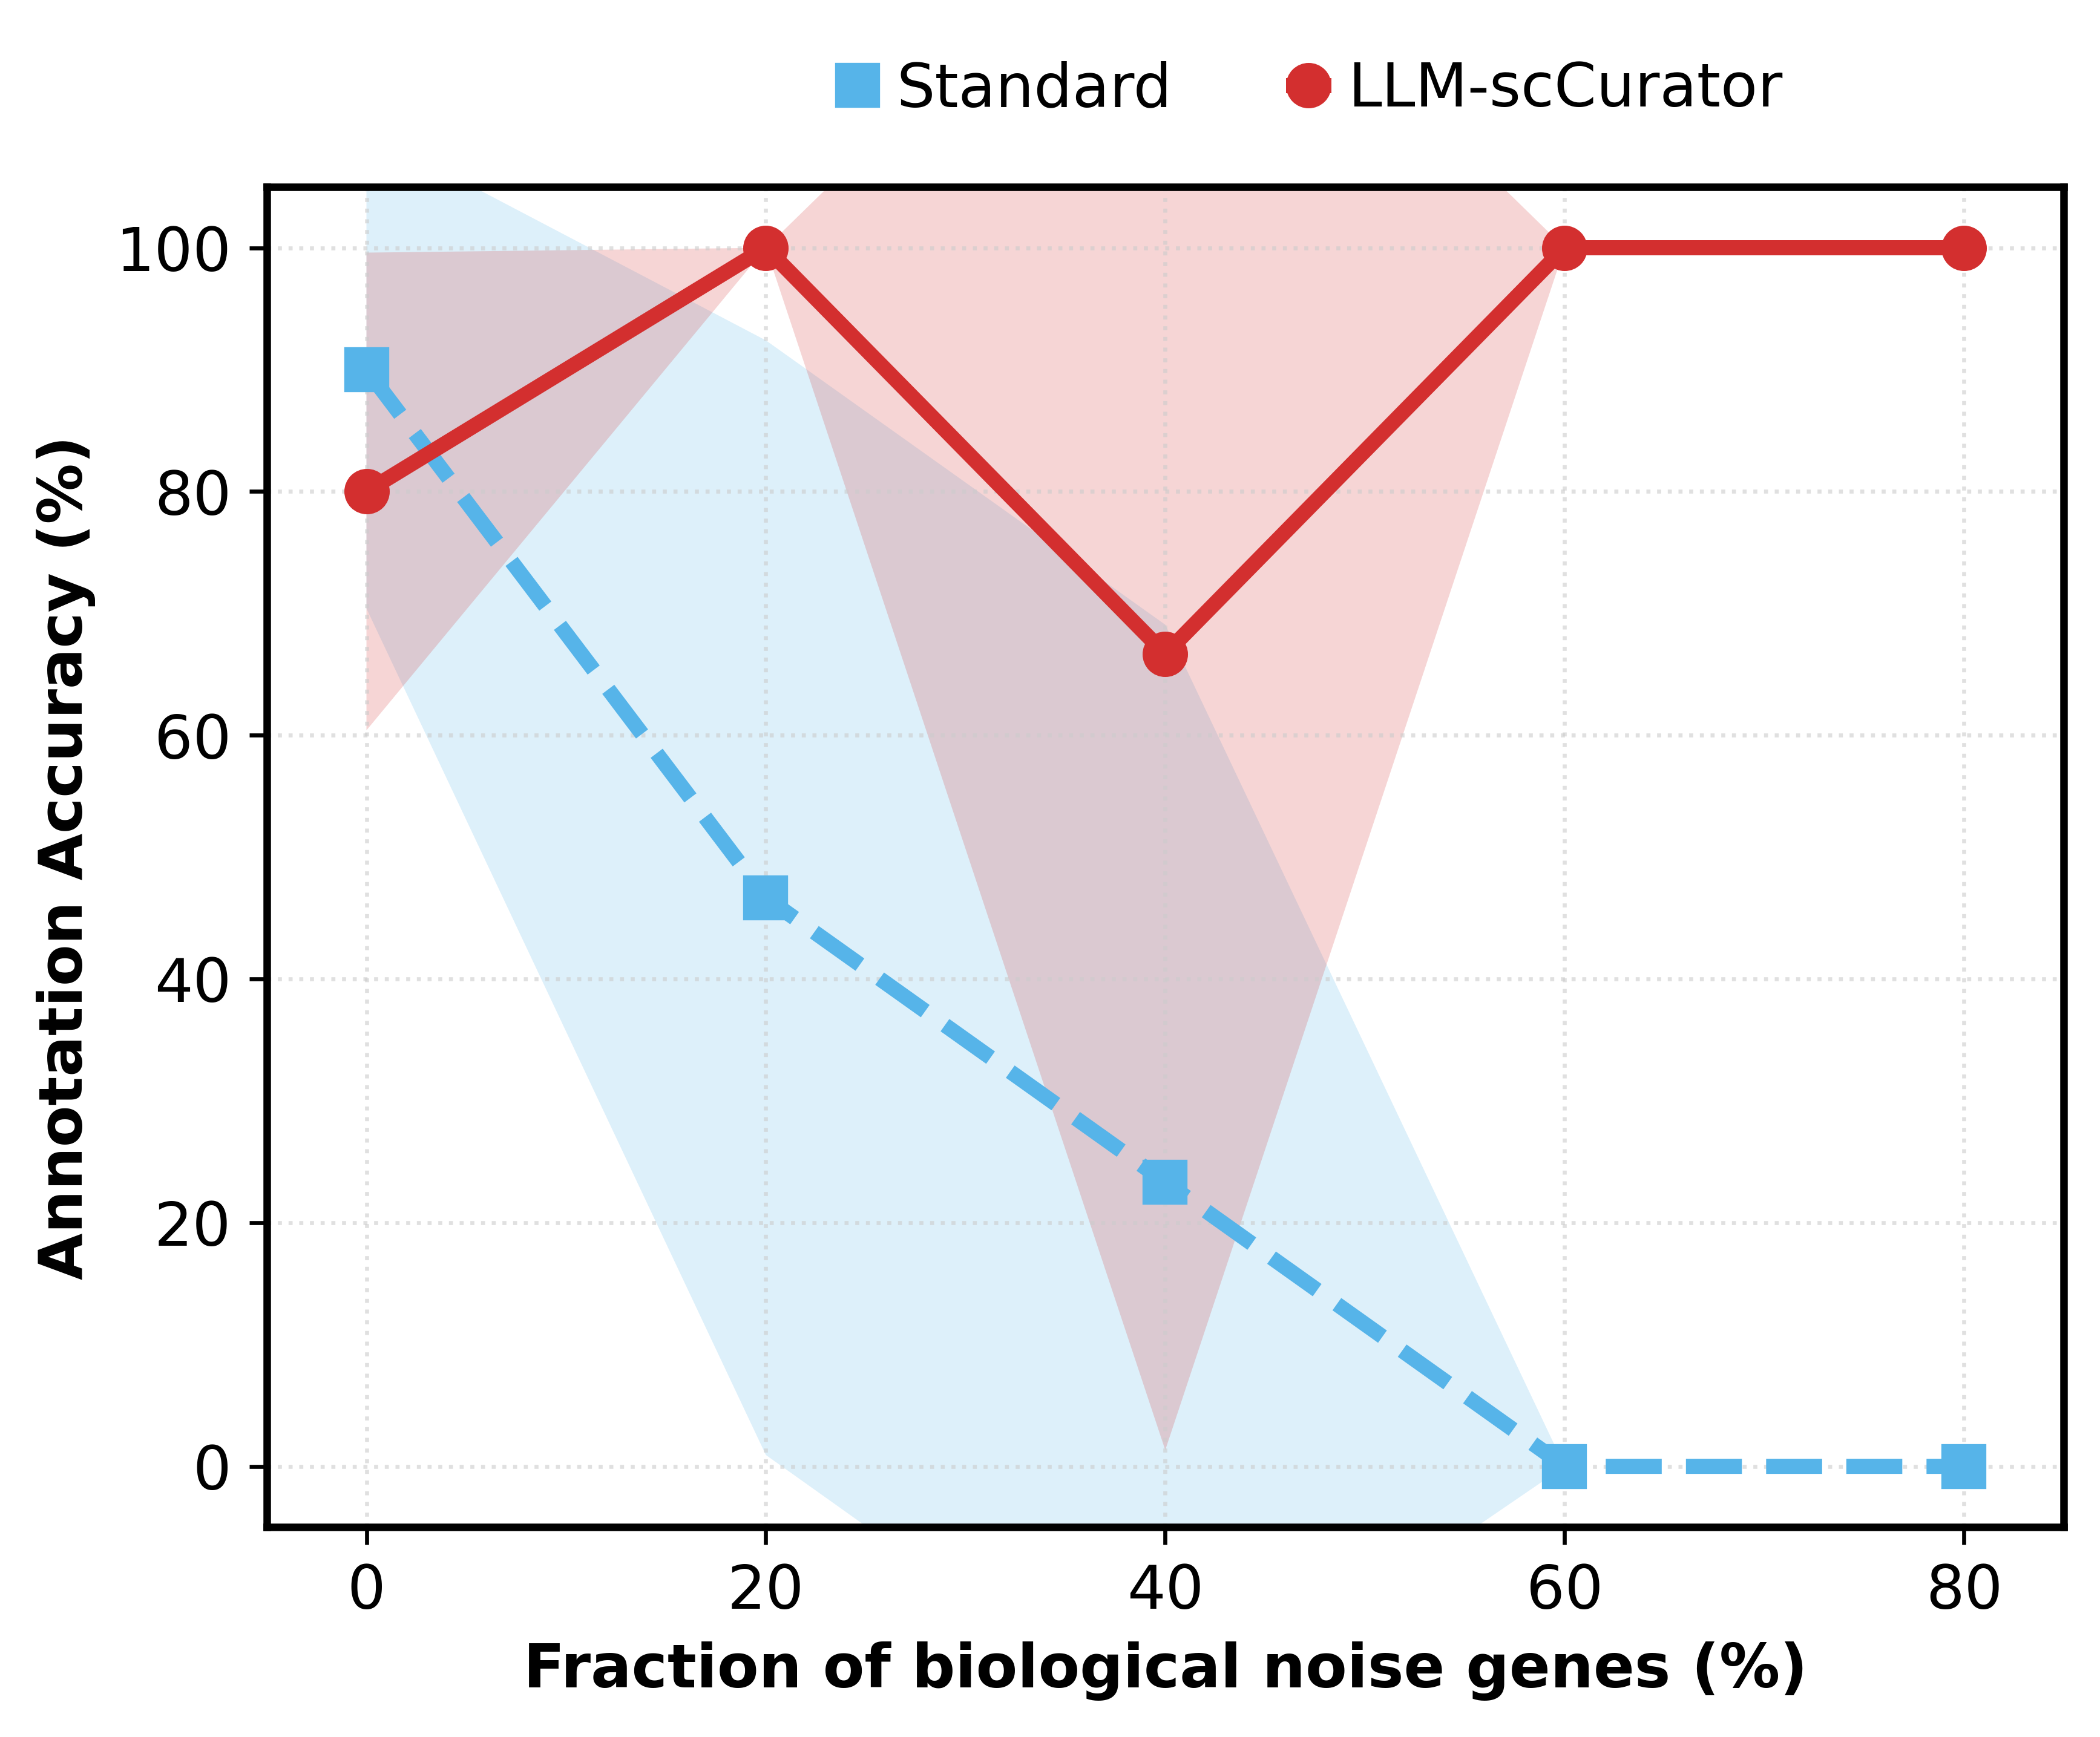

✅ Figure generated: /runs/20251201.v1/Fig2d_Resilience_Gap_withCI.png


In [ ]:
def plot_resilience_gap(sim_df):
    """
    Nature Methods Figure 2 Visualizer (with 95% CI bands):
    X-axis: Noise Contamination Rate (%)
    Y-axis: Annotation Accuracy (%)
    - Displays the average ± 95% CI for Standard and Curator as bands
    - Standard: Light Blue, Curator: Red
    """

    # ---- 0. Calculate mean / std / n for each Noise_Ratio ----
    grouped = sim_df.groupby("Noise_Ratio", as_index=True)

    stats = grouped.agg(
        mean_std=("Standard_Acc", "mean"),
        std_std=("Standard_Acc", "std"),
        n_std=("Standard_Acc", "count"),
        mean_cur=("Curator_Acc", "mean"),
        std_cur=("Curator_Acc", "std"),
        n_cur=("Curator_Acc", "count"),
    )

    # Set NaN to 0 when std (e.g., when n=1)
    stats["std_std"] = stats["std_std"].fillna(0.0)
    stats["std_cur"] = stats["std_cur"].fillna(0.0)

    # Standard Error & 95% Confidence Interval (Normal Approximation)
    stats["se_std"] = stats["std_std"] / np.sqrt(stats["n_std"].clip(lower=1))
    stats["se_cur"] = stats["std_cur"] / np.sqrt(stats["n_cur"].clip(lower=1))

    z = 1.96  # 95% CI

    stats["std_lower"] = stats["mean_std"] - z * stats["se_std"]
    stats["std_upper"] = stats["mean_std"] + z * stats["se_std"]
    stats["cur_lower"] = stats["mean_cur"] - z * stats["se_cur"]
    stats["cur_upper"] = stats["mean_cur"] + z * stats["se_cur"]

    # ---- 1. Prepare the X/Y axes ----
    x_vals = stats.index.values * 100.0  # 0.0–1.0 -> 0–100%

    y_std = stats["mean_std"].values
    y_cur = stats["mean_cur"].values

    std_lower = stats["std_lower"].values
    std_upper = stats["std_upper"].values
    cur_lower = stats["cur_lower"].values
    cur_upper = stats["cur_upper"].values

    # ---- 2. Style Settings ----
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
    plt.rcParams["font.size"] = 14
    plt.rcParams["axes.linewidth"] = 1.5

    fig, ax = plt.subplots(figsize=(6, 5), dpi=300)

    # ---- 3. Drawing the CI band  ----
    # Standard: Light Blue Band
    ax.fill_between(
        x_vals,
        std_lower,
        std_upper,
        alpha=0.20,
        edgecolor="none",
        facecolor="#56B4E9", # Water Color
        zorder=1,
    )

    # Curator: Red Band
    ax.fill_between(
        x_vals,
        cur_lower,
        cur_upper,
        alpha=0.20,
        edgecolor="none",
        facecolor="#D32F2F",  # Red Color
        zorder=1,
    )

    # ---- 4. Average line ----
    # Curator (Hero Line) -
    line_cur, = ax.plot(
        x_vals,
        y_cur,
        marker="o",
        color="#D32F2F", # Red Colo
        linewidth=3,
        markersize=8,
        label="LLM-scCurator",
        zorder=10,
    )

    # Standard (Baseline) -
    line_std, = ax.plot(
        x_vals,
        y_std,
        marker="s",
        color="#56B4E9",  # Water Color
        linewidth=3,
        linestyle="--",
        markersize=8,
        label="Standard LLM",
        zorder=9,
    )

    # ---- 5. Axis, Label, Grid ----
    ax.set_xlabel("Fraction of biological noise genes (%)", fontweight="bold", fontsize=12)
    ax.set_ylabel("Annotation Accuracy (%)", fontweight="bold", fontsize=12)

    ax.set_ylim(-5, 105)
    ax.set_xlim(-5, 85)
    ax.set_xticks([0, 20, 40, 60, 80])

    ax.grid(True, linestyle=":", alpha=0.6)

    # ---- 6. Legend ----
    ax.legend(
        handles=[line_std, line_cur],
        labels=["Standard", "LLM-scCurator"],
        ncol=2,
        bbox_to_anchor=(0.29, 1.01),
        frameon=False,
        fontsize=12,
    )


    ax.set_title("", fontsize=14, pad=15)

    plt.tight_layout()
    out_path = f"{OUT_DIR}/Fig2d_Resilience_Gap_withCI.png"
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Figure generated: {out_path}")

plot_resilience_gap(sim_df)